In [1]:
from args_experiments import *
from models import *
from load_data import *
from training import *
from utils import *

import random
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
args = args_cmapss()
args_encoder = args_seq2graph()
print(args)
print(args_encoder)

Namespace(batch_size=128, cuda=True, device=device(type='cuda'), epochs_adam=1000, hidden_GC=[4, 4], lag=2, lmbd_prox=0.005, lmbd_ridge=0.005, lr=0.0005, num_atoms=10, path='/data/data_cmapss_001/', prediction_steps=1, proximal_gradient=True, seed=1234, sparsity_min=0.05, stationary=True, suffix='_cmapss_001', time_steps=25)
Namespace(batch_size=64, encoder_hidden=64, epochs=600, lmbda=0.001, lr=0.0005, tau=0.5)


In [3]:
if args.suffix == '_springs10':
    train_loader, valid_loader, test_loader = load_springs_data(path=args.path, batch_size=args_encoder.batch_size,
                                                                dataset_name=args.suffix, shuffle=True)
elif args.suffix == '_cmapss_001':
    train_loader, valid_loader, test_loader = load_cmapss_data(args.path, args_encoder.batch_size,
                                                               args.time_steps, shuffle=True)

In [4]:
args.num_atoms, args.time_steps, args.in_dim = train_loader.dataset[0][0].shape
args.first_hidden = args.hidden_GC[0]

Text(0.5, 1.0, 'Sample from train set')

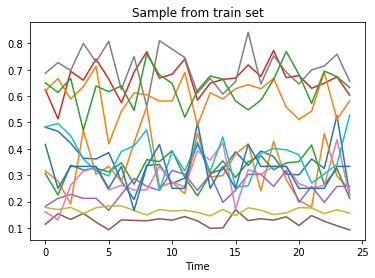

In [5]:
plt.plot(train_loader.dataset[10][0].squeeze().numpy().T);
plt.xlabel('Time')
plt.title('Sample from train set')

### GL-VAR model

In [6]:
g = GC(G_i, args.num_atoms, args.hidden_GC, 1, lag=args.lag, activation=nn.ReLU()).to(args.device)

/home/epineau/anaconda3/envs/edouard/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [7]:
g.load_state_dict(torch.load(os.getcwd() + '/weights_cmapss_001/g_sparse' + args.suffix + '.pt'))

W_prior = torch.stack([m.layers[0].weight.squeeze(-1) for m in g.model_list])
adjacency = (W_prior.sum(-1).sum(1) != 0).float().unsqueeze(1).unsqueeze(-1)
adjacency[range(args.num_atoms), :, range(args.num_atoms), :] = 0

if g.bias:
    bias_prior = torch.stack([m.layers[0].bias.data for m in g.model_list]).unsqueeze(0).unsqueeze(-1)
else:
    bias_prior = torch.zeros([1, args.num_atoms, g.model_list[0].layers[0].weight.shape[0], 1])

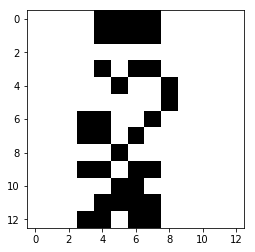

In [8]:
plt.imshow(adjacency.squeeze().cpu().detach().numpy(), cmap='binary');


##### This graph has been obtained with the notebook 'graph_inference_cmapss_001.ipynb'. 

### Inference function $F_\theta$

In [9]:
f_theta = RelationalEncoder(args.time_steps*args.in_dim, 
                                    args_encoder.encoder_hidden, 
                                    args.lag*args.first_hidden)
f_theta.P_prior = nn.Parameter(torch.zeros_like(W_prior))

f_theta = f_theta.to(args.device)

off_diag = np.ones([args.num_atoms, args.num_atoms])

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec).to(args.device)
rel_send = torch.FloatTensor(rel_send).to(args.device)

optimizer_encoder = optim.Adam(f_theta.parameters(), lr=args_encoder.lr)
scheduler_encoder = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=100, gamma=0.9)

### Train Seq2Graph

In [10]:
eta = 5e-4

for epoch in range(args_encoder.epochs):
    train_seq2graph_epoch(epoch, f_theta, g, train_loader, optimizer_encoder, scheduler_encoder, 
                          eta, rel_rec, rel_send, args)

Epoch: 0000 loss: 21.15574 reg: 986.39717
Epoch: 0025 loss: 2.28257 reg: 507.62536
Epoch: 0050 loss: 1.93723 reg: 262.72977
Epoch: 0075 loss: 1.84516 reg: 171.94903
Epoch: 0100 loss: 1.81641 reg: 115.76917
Epoch: 0125 loss: 1.79066 reg: 88.31711
Epoch: 0150 loss: 1.77808 reg: 73.56266
Epoch: 0175 loss: 1.77500 reg: 64.28636
Epoch: 0200 loss: 1.76676 reg: 57.64659
Epoch: 0225 loss: 1.76585 reg: 54.26356
Epoch: 0250 loss: 1.75688 reg: 51.51511
Epoch: 0275 loss: 1.75463 reg: 49.71311
Epoch: 0300 loss: 1.75209 reg: 48.26049
Epoch: 0325 loss: 1.75040 reg: 47.01419
Epoch: 0350 loss: 1.74533 reg: 46.32932
Epoch: 0375 loss: 1.74328 reg: 45.24924
Epoch: 0400 loss: 1.74375 reg: 44.88846
Epoch: 0425 loss: 1.74019 reg: 44.84755
Epoch: 0450 loss: 1.73711 reg: 44.36509
Epoch: 0475 loss: 1.73581 reg: 44.46348
Epoch: 0500 loss: 1.73055 reg: 44.03342
Epoch: 0525 loss: 1.73192 reg: 43.89359
Epoch: 0550 loss: 1.72937 reg: 44.30656
Epoch: 0575 loss: 1.72931 reg: 43.87204


In [11]:
torch.save(f_theta.state_dict(), os.getcwd() + '/weights' + args.suffix + '/seq2graph' + args.suffix + '.pt')

### Drawing of the results for the Seq2Graph trained above

#### Mean time before default

In [12]:
g.load_state_dict(torch.load(os.getcwd() + '/weights_cmapss_001/g_sparse' + args.suffix + '.pt'))
f_theta.load_state_dict(torch.load(os.getcwd() +'/weights' + args.suffix + '/seq2graph' + args.suffix + '.pt'))

###### For validation set

In [13]:
W_valid, l_valid = [], []
for batch_idx, (data, label) in enumerate(valid_loader):
    optimizer_encoder.zero_grad()
    if args.cuda:
        data = data.cuda()

    W = f_theta(data, rel_rec, rel_send)
    W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.first_hidden, args.lag)
    W = W.permute(0, 1, 3, 2, 4).mul(adjacency) # + W_prior.unsqueeze(0)
    
    W_valid.append(W.cpu().detach().numpy())
    l_valid.append(label)
W_valid = np.concatenate(W_valid)
W_valid = W_valid.sum(-1)

l_valid = np.concatenate(l_valid)
l_valid = np.concatenate([l_valid, np.zeros(1)])

In [14]:
breaks = np.where(l_valid == 0)[0]
start_valid = breaks[:-1]
stop_valid = breaks[1:]-1
W_ref = np.expand_dims(W_valid[start_valid[4]], 0)

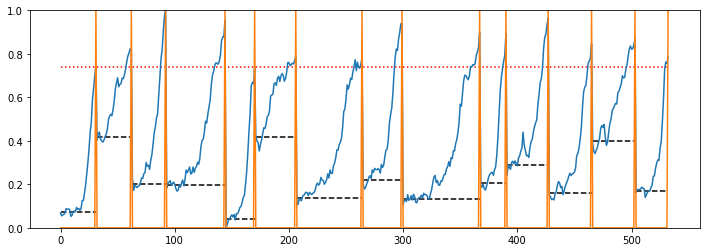

In [15]:
len_plot = start_valid[-1]
breaks = np.where(l_valid[:-1] == 0)[0]

plt.figure(figsize=(12, 4))
plt.ylim(0, 1)

ageing_curve_valid = np.array([((W_ref - w)**2).sum() for w in W_valid])
M_valid = np.max(ageing_curve_valid)
m_valid = np.min(ageing_curve_valid)
ageing_curve_valid = (ageing_curve_valid - m_valid) / (M_valid - m_valid)

thres = ageing_curve_valid[stop_valid].min()

plt.plot(ageing_curve_valid[:len_plot])
plt.plot((np.diff(l_valid) != 1).astype(int)[:len_plot])
plt.hlines(thres, 0, len_plot, color='red', linestyles='dotted')

for b, e in zip(start_valid[start_valid<len_plot], stop_valid[start_valid<len_plot]):
    plt.hlines(ageing_curve_valid[b:b+10].mean(), b, e, linestyles='dashed')

###### For test set

In [16]:
W_test, l_test = [], []
for batch_idx, (data, label) in enumerate(test_loader):
    optimizer_encoder.zero_grad()
    if args.cuda:
        data = data.cuda()

    W = f_theta(data, rel_rec, rel_send)
    W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.hidden_GC[0], args.lag)
    W = W.permute(0, 1, 3, 2, 4).mul(adjacency) # + W_prior.unsqueeze(0)
    
    W_test.append(W.cpu().detach().numpy())
    l_test.append(label)
W_test = np.concatenate(W_test)
W_test = W_test.sum(-1)

l_test = np.concatenate(l_test)
l_test = np.concatenate([l_test, np.zeros(1)])

In [17]:
breaks = np.where(l_test == 0)[0]
start_test = breaks[:-1]
stop_test = breaks[1:]-1

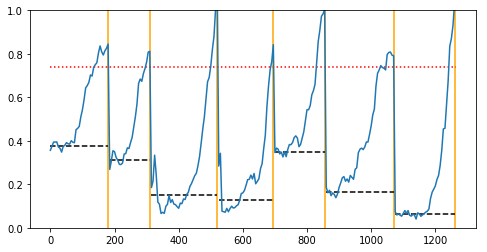

In [18]:
len_plot = start_test[7]
plt.figure(figsize=(8, 4))
plt.ylim(0, 1)

ageing_curve_test = np.array([(((W_ref - w)**2).sum()-m_valid)/(M_valid-m_valid) for w in W_test])

plt.plot(np.arange(len_plot)*5, ageing_curve_test[:len_plot])

for i in np.where(np.diff(l_test[:len_plot+1]) != 1)[0]:
    plt.vlines(i*5, 0, 1, colors='orange')
# plt.plot((np.diff(l_test) != 1).astype(int)[:len_plot])
plt.hlines(thres, 0, len_plot*5, color='red', linestyles='dotted', colors='red')

for b, e in zip(start_test[start_test<len_plot], stop_test[start_test<len_plot]):
    plt.hlines(ageing_curve_test[b:b+10].mean(), b*5, e*5, linestyles='dashed')

In [19]:
alarm_curve_test = (ageing_curve_test > thres).astype(float)

true_alarm_curve = np.zeros_like(ageing_curve_test)
true_alarm_curve[stop_test] = 1

default_detection = np.mean((alarm_curve_test == true_alarm_curve)[true_alarm_curve.astype(bool)].astype(float))
print("Default detection: {:.2f}%".format(default_detection*100))

Default detection: 100.00%


In [20]:
aps = []
for mtbf in range(1, 10):
    true_alarm_curve_test = np.zeros_like(ageing_curve_test)

    for i in range(mtbf):
        true_alarm_curve_test[stop_test-i] = 1
    
    precision, recall, thresholds = precision_recall_curve(true_alarm_curve_test, ageing_curve_test)
    aps.append(average_precision_score(true_alarm_curve_test, ageing_curve_test))

Text(0.5, 0, 'Number of time steps before default')

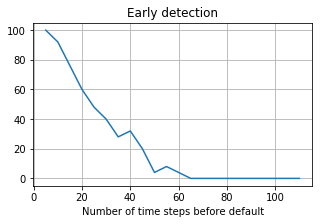

In [21]:
detection_default_curve = []
for security_limit in range(np.diff(stop_test).min()):
    true_alarm_curve = np.zeros_like(ageing_curve_test)
    true_alarm_curve[stop_test - security_limit] = 1
    
    default_detection = np.mean((alarm_curve_test == true_alarm_curve)[true_alarm_curve.astype(bool)].astype(float))
    detection_default_curve.append(default_detection*100)
    
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, len(detection_default_curve)+1)*5, detection_default_curve, label='Mean alarm')
plt.grid()
plt.title('Early detection')
plt.xlabel('Number of time steps before default')

Text(0.5, 0, 'Number of time steps before default')

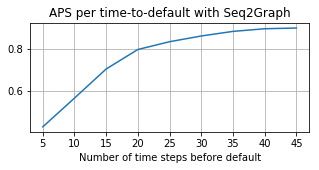

In [22]:
plt.figure(figsize=(5, 2))
plt.plot(np.arange(1, 10)*5, aps)
plt.grid()
plt.title('APS per time-to-default with Seq2Graph')
plt.xlabel('Number of time steps before default')

### Drawing the results of several Seq2Graph models (figures in the paper)

In [23]:
all_aps = []
all_detection_default_curves = []
mean_time_valid, mean_time_test = [], []

for i in range(1, 8):
    print('Model: ' + str(i))
    
    W_valid, l_valid = [], []
    all_aps_per_model = []
    
    f_theta.load_state_dict(torch.load(os.getcwd() + '/weights' + args.suffix + '/seq2graph' 
                                       + args.suffix + '_' + str(i) + '.pt'))
    
    for batch_idx, (data, label) in enumerate(valid_loader):
        optimizer_encoder.zero_grad()
        data = data.to(args.device)

        W = f_theta(data, rel_rec, rel_send)
        W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.hidden_GC[0], args.lag)
        W = W.permute(0, 1, 3, 2, 4).mul(adjacency)
        W_valid.append(W.cpu().detach().numpy())
        l_valid.append(label)
        
    W_valid = np.concatenate(W_valid)
    W_valid = W_valid.sum(-1)
    
    l_valid = np.concatenate(l_valid)
    l_valid = np.concatenate([l_valid, np.zeros(1)])
    
    breaks = np.where(l_valid == 0)[0]
    start_valid = breaks[:-1]
    stop_valid = breaks[1:]-1
    
    W_test, l_test = [], []
    for batch_idx, (data, label) in enumerate(test_loader):
        optimizer_encoder.zero_grad()
        data = data.to(args.device)
        
        W = f_theta(data, rel_rec, rel_send)
        W = W.contiguous().view(-1, args.num_atoms, args.num_atoms, args.hidden_GC[0], args.lag)
        W = W.permute(0, 1, 3, 2, 4).mul(adjacency)
        
        W_test.append(W.cpu().detach().numpy())
        l_test.append(label)
        
    W_test = np.concatenate(W_test)
    W_test = W_test.sum(-1)
    
    l_test = np.concatenate(l_test)
    l_test = np.concatenate([l_test, np.zeros(1)])

    breaks = np.where(l_test == 0)[0]
    start_test = breaks[:-1]
    stop_test = breaks[1:]-1
    
    for s in start_valid:
        W_ref = W_valid[s]
        
        ageing_curve_valid = np.array([((W_ref - w)**2).sum() for w in W_valid])
        M_valid = np.max(ageing_curve_valid)
        m_valid = np.min(ageing_curve_valid)
        ageing_curve_valid = (ageing_curve_valid - m_valid) / (M_valid - m_valid)

        thres = ageing_curve_valid[stop_valid].min()
        alarm_curve_valid = (ageing_curve_valid >= thres).astype(float)

        # Test

        ageing_curve_test = np.array([((W_ref - w)**2).sum() for w in W_test])
        ageing_curve_test = (ageing_curve_test- m_valid) / (M_valid - m_valid)

        alarm_curve_test = (ageing_curve_test >= thres).astype(float)
        
        detection_default_curve = []
        for security_limit in range(np.diff(stop_test).min()):
            true_alarm_curve = np.zeros_like(ageing_curve_test)
            true_alarm_curve[stop_test - security_limit] = 1

            default_detection = np.mean((alarm_curve_test == true_alarm_curve)[true_alarm_curve.astype(bool)].astype(float))
            detection_default_curve.append(default_detection*100)

        sup_thres_test = np.where(ageing_curve_test >= thres)[0]
        mean_time_test.append((np.mean([((sup_thres_test > b).astype(float)*(sup_thres_test <= e).astype(float)).sum() for b, e in zip(start_test, stop_test)])))

        all_detection_default_curves.append(detection_default_curve)
        
        aps = []
        for mtbf in range(1, 22):
            true_alarm_curve_test = np.zeros_like(ageing_curve_test)

            for security_limit in range(mtbf):
                true_alarm_curve_test[stop_test-security_limit] = 1

            precision, recall, thresholds = precision_recall_curve(true_alarm_curve_test, ageing_curve_test)
            aps.append(average_precision_score(true_alarm_curve_test, ageing_curve_test))

        all_aps_per_model.append(np.array(aps))
        
    all_aps.append(np.array(all_aps_per_model))

Model: 1
Model: 2
Model: 3
Model: 4
Model: 5
Model: 6
Model: 7


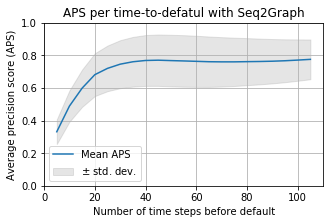

In [24]:
mean_curves = np.concatenate(all_aps).mean(0)
std_curves = np.concatenate(all_aps).std(0)

plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, len(mean_curves)+1)*5, mean_curves, label='Mean APS')
tprs_upper = mean_curves + std_curves
tprs_lower = mean_curves - std_curves
plt.fill_between(np.arange(1, len(mean_curves)+1)*5, tprs_lower, tprs_upper, color='grey', 
                 alpha=.2, label=r'$\pm$ std. dev.')

plt.grid()
plt.title('APS per time-to-defatul with Seq2Graph')

plt.xlabel('Number of time steps before default')
plt.ylabel('Average precision score (APS)')
plt.legend()
plt.ylim(0, 1);

(-5, 100)

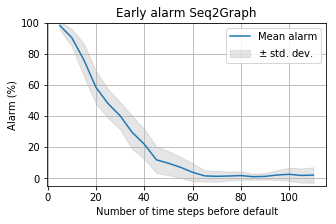

In [25]:
mean_curves = np.array(all_detection_default_curves).mean(0)
std_curves = np.array(all_detection_default_curves).std(0)

plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, len(mean_curves)+1)*5, mean_curves, label='Mean alarm')
tprs_upper = mean_curves + std_curves
tprs_lower = mean_curves - std_curves
plt.fill_between(np.arange(1, len(mean_curves)+1)*5, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ std. dev.')

plt.grid()
plt.title('Early alarm Seq2Graph')

plt.xlabel('Number of time steps before default')
plt.ylabel('Alarm (%)')
plt.legend()
plt.ylim(-5, 100)